In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
from operator import itemgetter

import timeit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from itertools import count
iid = count()

### 0. Preprocessing

In [2]:
from pathlib import Path

train_X = []
train_y = []
mini_X = []
mini_y = []
mini_X_test = []
mini_y_test = []


dev = True

if (dev):
    train_size = int(5000*.7)
    if (not Path('Datasets/train_med_x.csv').is_file()):
        train_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
        train_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")
        mini_X = train_X[:train_size]
        mini_y = train_y[:train_size]
        mini_X_test = train_X[train_size:5000]
        mini_y_test = train_y[train_size:5000]
        
        np.savetxt("Datasets/train_med_x.csv", mini_X, delimiter=",")
        np.savetxt("Datasets/train_med_y.csv", mini_y, delimiter=",")
        np.savetxt("Datasets/test_med_x.csv", mini_X_test, delimiter=",")
        np.savetxt("Datasets/test_med_y.csv", mini_y_test, delimiter=",")
    else:
        mini_X = np.loadtxt("Datasets/train_med_x.csv", delimiter=",")
        mini_y = np.loadtxt("Datasets/train_med_y.csv", delimiter=",")
        mini_X_test = np.loadtxt("Datasets/test_med_x.csv", delimiter=",")
        mini_y_test = np.loadtxt("Datasets/test_med_y.csv", delimiter=",")
else:
    mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
    mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")
    M,N = mini_X.shape
    train_size = int(M*.7)
    mini_X_test = mini_X[train_size:M]
    mini_y_test = mini_y[train_size:M]
    mini_X = mini_X[:train_size]
    mini_y = mini_y[:train_size]

#### Reshape to easily visualize while cleaning data

In [3]:
%%time
x = mini_X.reshape(-1, 64, 64)

imgs = []
for idx in range(len(x)):
    img_id = next(iid)
    cv2.imwrite('Output/{}.jpg'.format(img_id), 255-x[idx])
    imgs.append(cv2.imread('Output/{}.jpg'.format(img_id), 0))

CPU times: user 417 ms, sys: 171 ms, total: 588 ms
Wall time: 643 ms


We will first transform to binary image (black, white):

In [4]:
%%time
bin_imgs = []
for img in imgs:
    _, bin_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin_imgs.append(bin_img)

CPU times: user 8.69 ms, sys: 888 µs, total: 9.58 ms
Wall time: 10.3 ms


Then we will remove the noice by dilatating and eroding the image:

In [5]:
denoised_imgs = []
for bin_img in bin_imgs:
    dilatated = cv2.dilate(bin_img, np.ones((3,3)))
    denoised_imgs.append(cv2.erode(dilatated, np.ones((2,2))))

Lets visualize the transformations:

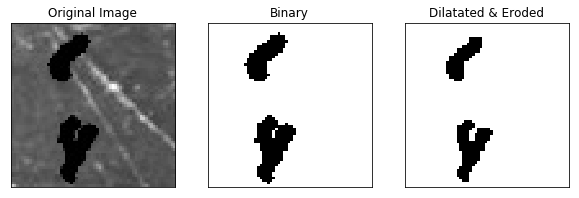

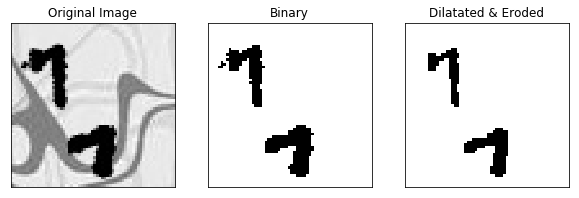

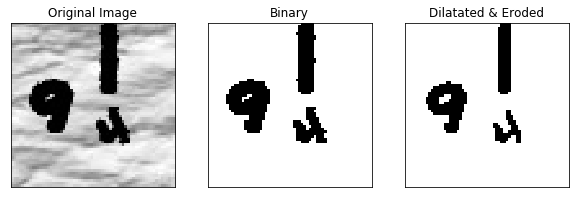

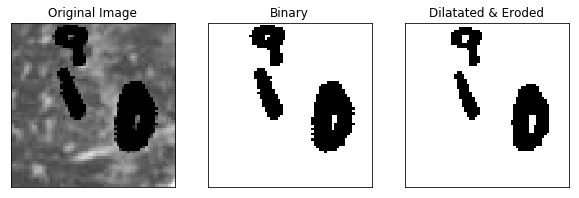

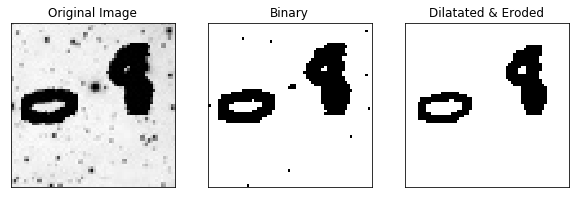

In [6]:
def plot_images(images, titles):
    cols = len(images)
    rows = len(images[0])
    for r in range(rows):
        for c in range(cols):
            plt.subplot(1,cols,c+1)
            plt.imshow(images[c][r],'gray')
            plt.title(titles[c])
            plt.xticks([]),plt.yticks([])
        
        plt.show()
        
titles = ['Original Image', 'Binary', 'Dilatated & Eroded']
images = [imgs[:5], bin_imgs[:5], denoised_imgs[:5]]
plot_images(images, titles)

Finally we will blur in order to smooth any edges __(TEST IF THIS IS ACTUALLY USEFUL)__

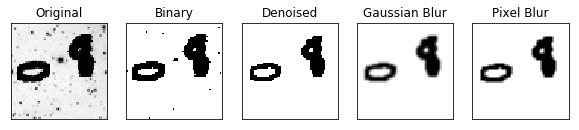

In [7]:
blurred_imgs = []
for denoised_img in denoised_imgs:
    blurred_imgs.append(cv2.blur(denoised_img,(2,2)))

random_idx = 4
blur = cv2.blur(denoised_imgs[random_idx],(2,2))
gaussian_blur = cv2.GaussianBlur(denoised_imgs[random_idx],(3,3),0)    
plt.subplot(151),plt.imshow(imgs[random_idx],'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(152),plt.imshow(bin_imgs[random_idx],'gray'),plt.title('Binary')
plt.xticks([]), plt.yticks([])
plt.subplot(153),plt.imshow(denoised_imgs[random_idx],'gray'),plt.title('Denoised')
plt.xticks([]), plt.yticks([])
plt.subplot(154),plt.imshow(gaussian_blur,'gray'),plt.title('Gaussian Blur')
plt.xticks([]), plt.yticks([])
plt.subplot(155),plt.imshow(blur,'gray'),plt.title('Pixel Blur')
plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data

from PIL import Image

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import time
from __future__ import print_function


In [9]:
class CNN(nn.Module):
    
    # Can choose to take dimensions in constructor, but for now just keeping them variable since unsure about
    # how many variables to have in the constructor based on design
    def __init__(self, scale):
        self.print = True
        self.scale = scale
        super(CNN, self).__init__() # init recursively
        
        self.layer1 = nn.Sequential(
            nn.Dropout(p=0.5), # Random p% of nodes are cancelled - this is for regularization
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(5, 5), padding=1, stride=3),
            nn.ReLU(),
            nn.BatchNorm2d(12)
        )
        self.layer2 = nn.Sequential(
            nn.Dropout(p=0.5), # Random p% of nodes are cancelled - this is for regularization
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=(3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(32),
        )
        self.layer3 = nn.Sequential(
            nn.Dropout(p=0.5), # Random p% of nodes are cancelled - this is for regularization
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(48),
        )
        self.layer4 = nn.Sequential(
            nn.Dropout(p=0.5), # Random p% of nodes are cancelled - this is for regularization
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),
        )
        self.layer5 = nn.Sequential(
            nn.Dropout(p=0.5), # Random p% of nodes are cancelled - this is for regularization
            nn.Conv2d(in_channels=48, out_channels=32, kernel_size=(3, 3), padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(int(self.scale*64*64),int(self.scale*64*64)),
        )
        self.layer7 = nn.Sequential(
            nn.Linear(int(self.scale*64*64),int(self.scale*64*64)),
        )
        self.layer8 = nn.Sequential(
            nn.Linear(int(self.scale*64*64),10),
        )
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view( -1 , int(self.scale*64*64))
        out = self.layer6(out)
        if(self.print):
            self.print = False
            print("output size: ", out.size())
        return out

In [10]:
import torch.utils.data as data
class DatasetKaggle(data.Dataset):
    def __init__(self, np_data_x, np_data_y, transform=None):
        self.data = np_data_x
        self.labels = np_data_y
        if (transform is not None):
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self,index):
        sample = self.data[index]
        sample = sample.reshape(64,64,1)
        sample = self.transform(sample)
        
        label = int(self.labels[index])
        
        return sample, label
    
    def __len__(self):
        return len(self.labels)

In [11]:
cuda_available = torch.cuda.is_available()

train = DatasetKaggle(mini_X, mini_y)
test = DatasetKaggle(mini_X_test, mini_y_test)

batch_size = 64

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
clf = CNN(1/2048*16)
if cuda_available:
    clf = clf.cuda()

optimizer = torch.optim.Adam(clf.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()


cuda_available = torch.cuda.is_available()

# y_onehot = torch.LongTensor(batch_size, 10)
for epoch in range(50):

    start_time = timeit.default_timer()
    losses = []
    # Train
    for batch_idx, data in enumerate(trainloader):
        inputs, labels = data
        
        if cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        inputs, labels = Variable(inputs), Variable(labels)
    
        outputs = clf(inputs)
        
        # Compute the loss
        loss = F.cross_entropy(outputs,labels)
        
        # Reset gradients to zero, perform a backward pass, and update the weights.
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, data in enumerate(testloader):
        inputs, labels = data
        if cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()

        inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
    elapsed = timeit.default_timer() - start_time
    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('Time for epoch: ', elapsed)
    print('--------------------------------------------------------------')
    clf.train()

output size:  torch.Size([64, 32])
Epoch : 0 Loss : 2.538 
Epoch : 0 Test Acc : 11.333
Time for epoch:  8.523761319000187
--------------------------------------------------------------
Epoch : 1 Loss : 2.323 
Epoch : 1 Test Acc : 11.333
Time for epoch:  8.137887516000774
--------------------------------------------------------------
Epoch : 2 Loss : 2.318 
Epoch : 2 Test Acc : 11.333
Time for epoch:  8.4458110509986
--------------------------------------------------------------
Epoch : 3 Loss : 2.307 
Epoch : 3 Test Acc : 11.333
Time for epoch:  8.360172952998255
--------------------------------------------------------------
Epoch : 4 Loss : 2.298 
Epoch : 4 Test Acc : 11.333
Time for epoch:  8.092229665002378
--------------------------------------------------------------
Epoch : 5 Loss : 2.286 
Epoch : 5 Test Acc : 11.333
Time for epoch:  8.277133812000102
--------------------------------------------------------------
Epoch : 6 Loss : 2.285 
Epoch : 6 Test Acc : 11.333
Time for epoch: